# Stochastic Nested Variance Reduction Gradient (SNVRG) and Stochastically Controlled Stochastic Gradient (SCSG) for Non-convex Optimization

This notebook implements the SNVRG algorithm proposed in this [paper](https://papers.nips.cc/paper/7648-stochastic-nested-variance-reduced-gradient-descent-for-nonconvex-optimization.pdf) by Dongruo Zhou et al.

We apply the SNVRG algorithm to a convex problem (Logistic regression with LASSO regularization) and a non-convex problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm

## 1. Toy Convex Problem: Logistic Regression with LASSO regularization

In [17]:
# Generate the data
n, p = 1000, 5

X = np.random.randn(n, p)
w = np.random.randn(p)

sigma = 1
xi = np.random.randn(n)

y = np.sign(X.dot(w) + sigma*xi)

In [18]:
# Define the loss function
def LASSO_loss(X, y, theta, lamda):
    '''Return the logistic LASSO loss for parameters `theta`.'''
    return np.mean(np.log(1.0 + np.exp(- y * X.dot(theta)))) + lamda * np.sum(np.abs(theta))

In [19]:
# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y/(1.0 + np.exp(y * X.dot(theta)))).dot(X) + LASSO_grad

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datum i.'''
    n = X.shape[0]
    LASSO_grad = lamda * ((theta >= 0).astype(np.int) * 2 - 1)
    return (1./n) * (- y[i]/(1.0 + np.exp(y[i] * X[i].dot(theta)))) * X[i] + LASSO_grad

In [20]:
# Define the SVRG algorithm
def SVRG(X, y, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    theta_history = np.zeros((max_iter_inner, p))
    
    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
    
    return theta_hat, theta_hat_history, loss_history

In [21]:
theta = np.random.randn(p)
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history = SVRG(X, y, theta, lamda=0.1, max_iter=100, max_iter_inner=100, step_size=0.05)

In [22]:
# Define the approximative minimum value of the loss function
svrg_min_loss = np.min(svrg_loss_history)

In [18]:
# Define the function to find the mod index
def find_index(t, loop_params):
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    updated_reference = theta_reference.copy()
    K, p = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, p))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    n = X.shape[0]
    K, p = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

In [24]:
def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, p))
    theta_history = []
    
    gradients = np.zeros((K+1, p))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
#     final_theta = np.mean(theta_history, axis=0)
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

In [25]:
def SNVRG(X, y, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
    
    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history

In [28]:
def SCSG(X, y, theta, lamda, max_iter, batch_params, mini_batch_params, step_size):
    theta_history = []
    loss_history = []
    if isinstance(batch_params, int):
        batch_params = [batch_params] * max_iter
    assert len(batch_params) == max_iter, 'Length of batch parameters ({}) should be the same as max iterations ({})'.format(len(batch_params), max_iter)
    
    if isinstance(mini_batch_params, int):
        mini_batch_params = [mini_batch_params] * max_iter
    assert len(mini_batch_params) == max_iter, 'Length of mini-batch parameters ({}) should be the same as max iterations ({})'.format(len(mini_batch_params), max_iter)
    
    indices = np.arange(X.shape[0])
    for t in range(max_iter):
        np.random.shuffle(indices)
        X_batch, y_batch = X[indices[:batch_params[t]]], y[indices[:batch_params[t]]]
        theta_hat = theta
        full_gradient = full_grad_loss(X_batch, y_batch, theta_hat, lamda)
        N = np.random.geometric(1.0 * mini_batch_params[t] / (batch_params[t] + mini_batch_params[t]))
        for k in range(N):
            i = k % (batch_params[t] // mini_batch_params[t])
            X_mini_batch, y_mini_batch = X[indices[i*mini_batch_params[t]:(i+1)*mini_batch_params[t]]], y[indices[i*mini_batch_params[t]:(i+1)*mini_batch_params[t]]]
            gradient = full_grad_loss(X_mini_batch, y_mini_batch, theta, lamda) - full_grad_loss(X_mini_batch, y_mini_batch, theta_hat, lamda) + full_gradient
            theta = theta - step_size * gradient
            
        theta_history.append(theta)
        loss_history.append(LASSO_loss(X, y, theta, lamda))
        
    return theta, theta_history, loss_history

First, we set the same parameters as those in SVRG to see if we can reproduce the result in SVRG.

In [29]:
theta = np.random.randn(p)
loop_params = [100]
base_batch_size = 1000
batch_params = [1]
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 2.0
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

In [30]:
theta = np.random.randn(p)
max_iter = 100
batch_params = 1000
mini_batch_params = 16
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 0.5 / L / (batch_params / mini_batch_params)
scsg_theta_hat, scsg_theta_hat_history, scsg_loss_history = SCSG(X, y, theta, 0.1, max_iter, batch_params, mini_batch_params, step_size)

In [31]:
snvrg_min_loss = np.min(snvrg_loss_history)
min_loss = np.min([svrg_min_loss, snvrg_min_loss])
scsg_min_loss = np.min(scsg_loss_history)
min_loss = np.min([min_loss, scsg_min_loss])

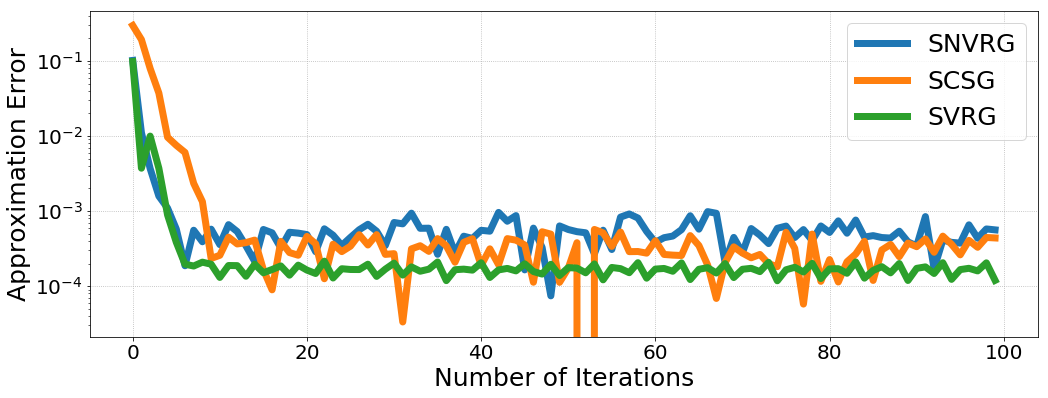

In [32]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(scsg_loss_history - min_loss, label='SCSG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the convergences of two algorithms are quite similar. Notice that SNVRG is more oscillating than SVRG which is because SNVRG chooses the parameter $\theta$ randomly in each epoch rather than taking the mean as in SVRG.

Now we test the performance of the real SNVRG by taking $K = 2$ as in the paper. And we choose the loop parameters $T_l = \{2, 2\}$, the batch parameters $B_l = \{128, 64\}$, the base batch size $B = 256$ and the step size parameter $M = 6L$ where $L$ is the Lipschitz constant, as suggested in the paper.

In [33]:
theta = np.random.randn(p)
loop_params = [2, 2]
base_batch_size = 256
batch_params = [128, 64]
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 6 * L
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(X, y, theta, 0.1, 100, loop_params, batch_params, base_batch_size, step_size)

In [38]:
theta = np.random.randn(p)
max_iter = 100
batch_params = 256
mini_batch_params = 16
L = np.linalg.norm((1./(4*n))*X.T.dot(X), ord=2)
step_size = 0.5 / L / (batch_params / mini_batch_params)
scsg_theta_hat, scsg_theta_hat_history, scsg_loss_history = SCSG(X, y, theta, 0.1, max_iter, batch_params, mini_batch_params, step_size)

In [39]:
snvrg_min_loss = np.min(snvrg_loss_history)
scsg_min_loss = np.min(scsg_loss_history)

In [40]:
min_loss = np.min([svrg_min_loss, snvrg_min_loss, scsg_min_loss])

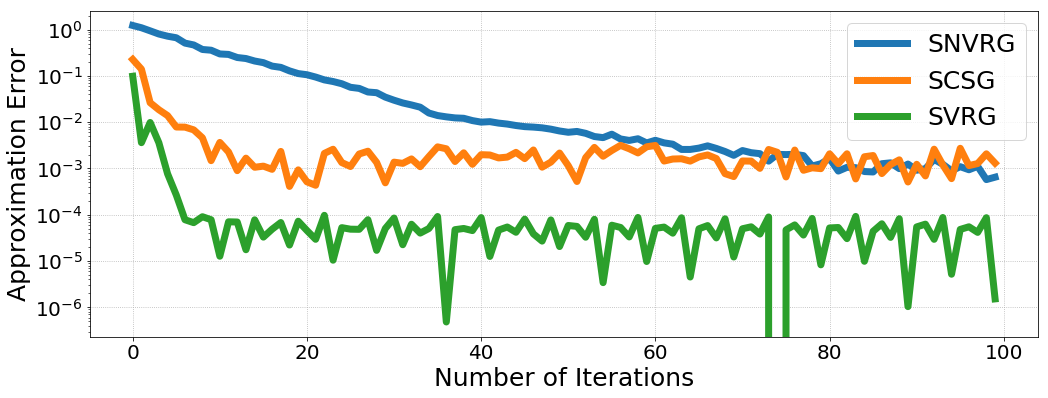

In [41]:
# Let us now plot the convergence in terms of values of loss
plt.figure(figsize=(17, 6))
plt.semilogy(snvrg_loss_history - min_loss, label='SNVRG', lw=7)
plt.semilogy(scsg_loss_history - min_loss, label='SCSG', lw=7)
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', lw=7)
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

We can see that the SNVRG converges slower at the beginning but it can attain similar performance as SVRG after around 50 iterations.

## 2. Non-convex Problem: MNIST dataset image classification
As presented in the paper, we take the image classification non-convex problem on MNIST dataset to see the performance of SNVRG.

In order to train the neural network efficiently, we use TensorFlow framework. Thus we reimplement the SNVRG algorithm in TensorFlow here.

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
# Image size in MNIST dataset is (28, 28), so the first convolutional layer is applied with SAME padding, to fit with the LeNet architecture
def CNN_LeNet(images):
    net = tf.reshape(images, shape=[-1, 28, 28, 1])
    net = Conv2D(filters=6, kernel_size=5, strides=(1, 1), activation='relu', padding='SAME')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='VALID')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Flatten()(net)
    net = Dense(120, activation='relu')(net)
    net = Dense(84, activation='relu')(net)
    net = Dense(10, activation=None)(net)
    
    return net

In [4]:
def loss(y, pred):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(y, pred))
    return cross_entropy

In [5]:
class SVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
    
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, inner_iter, lr=None):
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(inner_iter):
            sample = np.random.randint(batch_size)
            feed_dict_single.append({input_ph[j]: input_data[j][sample:sample+1] for j in range(len(input_data))})
            
        for i in range(inner_iter):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [46]:
def update_reference_points_tf(parameters_references, parameters, r):
    K = len(parameters_references)
    for i in range(r, K):
        parameters_references[i] = parameters.copy()
    return parameters_references
    
def update_reference_gradients_tf(X, y, gradients, parameters_references, regularization, r, batch_params, base_batch_size):
    n = X.get_shape().as_list()[0]
    K = len(parameters_references)
    for l in range(r, K):
        indexes = tf.random.shuffle(tf.range(n))
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            y_pred = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l])
            cost = loss(tf.gather(y, batch_indexes), y_pred, regularization, parameters_references[l])
            gradients[l] = grad_loss(cost, parameters_references[l])
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            y_pred_new = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l])
            cost_new = loss(tf.gather(y, batch_indexes), y_pred_new, regularization, parameters_references[l])
            grad_new = grad_loss(cost_new, parameters_references[l])
            y_pred_old = CNN_LeNet(tf.gather(X, batch_indexes), parameters_references[l-1])
            cost_old = loss(tf.gather(y, batch_indexes), y_pred_old, regularization, parameters_references[l-1])
            grad_old = grad_loss(cost_old, parameters_references[l-1])
            for i in range(len(grad_new)):
                gradients[l][i] = grad_new[i] - grad_old[i]
            
    return gradients

In [26]:
class SNVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, K, learning_rate=1e-3):
        self.K = K
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._reference_gradient_ph = [[tf.placeholder(tf.float32, shape=v.get_shape()) for _, v in self._grads_and_vars]
                                       for _ in range(self.K+1)]
        
        self._update = self._compute_single_update
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
            
    def _compute_single_update(self, l):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (_, v) in enumerate(grads_and_vars):
            g = self._reference_gradient_ph[l][i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, loop_params, mini_batch_params):
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        gs, vs = zip(*self._grads_and_vars)
        shift_gradients = [[np.zeros(v.get_shape().as_list()) for v in vs] for _ in range(self.K+1)]
        shift_gradients[0] = sess.run(gs, feed_dict=feed_dict)
        
        reference_gradients = [[np.zeros(v.get_shape().as_list()) for v in vs] for _ in range(self.K+1)]
        reference_gradients[0] = sess.run(gs, feed_dict=feed_dict)
            
        prev_r = K
        for t in range(1, np.prod(loop_params)):      
            r = find_index(t, loop_params)
            if r < prev_r:
                gs, vs = zip(*self._grads_and_vars)
            prev_r = r
        
            for l in range(r, K+1):
                samples = np.random.choice(batch_size, size = mini_batch_params[l-1], replace=False)
                feed_dict_single = {input_ph[j]: input_data[j][samples] for j in range(len(input_data))}
                
                shift_gradients[l] = sess.run(gs, feed_dict=feed_dict_single)
                for i, g in enumerate(shift_gradients[l]):
                    reference_gradients[l][i] = g - shift_gradients[l-1][i]
                
            for l in range(K+1):
                feed_dict_single.update(dict(zip(self._reference_gradient_ph[l], reference_gradients[l])))
                _ = sess.run(self._update(l), feed_dict=feed_dict_single)

In [6]:
class SCSGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
        
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, mini_batch_size):
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(batch_size // mini_batch_size):
            feed_dict_single.append({input_ph[j]: input_data[j][i*mini_batch_size:(i+1)*mini_batch_size] 
                                             for j in range(len(input_data))})
            
        for i in range(batch_size // mini_batch_size):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [7]:
def evaluate(y, y_pred):
    preds = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y, axis=1)
    err = 1. - tf.reduce_mean(tf.cast(tf.equal(y_true, preds), tf.float32))
    return err

In [8]:
# load MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Adam Optimizer

In [35]:
tf.reset_default_graph()

lr = 0.01
epochs = 400
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.AdamOptimizer(learning_rate=lr)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    adam_loss_history = []
    adam_test_error_history = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        adam_loss_history.append(c)
        adam_test_error_history.append(err)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/400
	Loss: 2.3179640769958496 	Test Error: 0.8787000179290771
Epoch 2/400
	Loss: 2.239983081817627 	Test Error: 0.6037999987602234
Epoch 3/400
	Loss: 2.0797648429870605 	Test Error: 0.5507000088691711
Epoch 4/400
	Loss: 1.7331056594848633 	Test Error: 0.5097999572753906
Epoch 5/400
	Loss: 1.4907925128936768 	Test Error: 0.30729997158050537
Epoch 6/400
	Loss: 0.9709103107452393 	Test Error: 0.3367999792098999
Epoch 7/400
	Loss: 1.0367188453674316 	Test Error: 0.19099998474121094
Epoch 8/400
	Loss: 0.7587798833847046 	Test Error: 0.2720000147819519
Epoch 9/400
	Loss: 0.7540264129638672 	Test Error: 0.17419999837875366
Epoch 10/400
	Loss: 0.5950978398323059 	Test Error: 0.14069998264312744
Epoch 11/400
	Loss: 0.45294857025146484 	Test Error: 0.1395999789237976
Epoch 12/400
	Loss: 0.41479939222335815 	Test Error: 0.1462000012397766
Epoch 13/400
	Loss: 0.5199979543685913 	Test Error: 0.11699998378753662
Epoch 14/400
	Loss: 0.40933454036712646 	Test Error: 0.09759998321533203
Epoch 1

KeyboardInterrupt: 

### SVRG Optimizer

In [10]:
tf.reset_default_graph()

max_iter_inner = 64
lr = 0.01
epochs = 40
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SVRGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    svrg_loss_history = []
    svrg_test_error_history = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        optimizer.batch_update(sess, feed_dict, batch_size, max_iter_inner)
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        svrg_loss_history.append(c)
        svrg_test_error_history.append(err)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

10
10
10
0
1
2
3
4
5
6
7
8
9
Epoch 1/40
	Loss: 2.2775206565856934 	Test Error: 0.7583000063896179
Epoch 2/40


KeyboardInterrupt: 

### SNVRG Optimizer

In [27]:
tf.reset_default_graph()

epochs = 40
batch_size = 512
loop_params = [8, 8]
batch_params = [64, 4]
lr = 0.01
K = len(loop_params)

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SNVRGOptimizer(cost, K, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    snvrg_loss_history = []
    snvrg_test_error_history = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        optimizer.batch_update(sess, feed_dict, batch_size, loop_params, batch_params)
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        snvrg_loss_history.append(c)
        snvrg_test_error_history.append(err)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/40
	Loss: 2.229775905609131 	Test Error: 0.7764999866485596
Epoch 2/40
	Loss: 2.058763265609741 	Test Error: 0.6585999727249146
Epoch 3/40
	Loss: 1.3690745830535889 	Test Error: 0.41600000858306885
Epoch 4/40
	Loss: 0.930652379989624 	Test Error: 0.2856000065803528
Epoch 5/40
	Loss: 0.8562073707580566 	Test Error: 0.25609999895095825
Epoch 6/40
	Loss: 0.839198887348175 	Test Error: 0.2874000072479248
Epoch 7/40
	Loss: 0.7316765189170837 	Test Error: 0.27410000562667847
Epoch 8/40
	Loss: 0.5442720651626587 	Test Error: 0.1972000002861023
Epoch 9/40


KeyboardInterrupt: 

### SCSG Optimizer

In [13]:
tf.reset_default_graph()

lr = 0.001
epochs = 40
batch_size = 512
mini_batch_size = 32
ratio = 32
fix_batch = False

X = tf.placeholder(dtype='float32', shape=(None, 784))
y = tf.placeholder(dtype='float32', shape=(None, 10))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SCSGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    scsg_loss_history = []
    scsg_test_error_history = []
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        if not fix_batch:
            batch_size = int((epoch+1)**1.5)
            mini_batch_size = max(1, batch_size // ratio)
            
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch[0], y: batch[1]}
        optimizer.batch_update(sess, feed_dict, batch_size, mini_batch_size)
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: mnist.test.images, y: mnist.test.labels})
        
        scsg_loss_history.append(c)
        scsg_test_error_history.append(err)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/40
	Loss: 2.0921108722686768 	Test Error: 0.8946999907493591
Epoch 2/40


KeyboardInterrupt: 